# Quantum circuit Born machine
## Experiment 1: Non-differentiable learning

In this notebook the quantum circuit born machine with non-differentiable learning is implemented and tested by learning and subsequently reproducing the a simple probability distribution.
For a complete reference of the implementation and explanation of the related theory see the main text of the project. For a complex application of this implementation see the notebook
ending in suffix Real instead of Basic.

Note that this code does not perform checks for validity of the input, for this reason the code should be reused with caution.

In [1]:
from qiskit.version import get_version_info as qiskitversion

In [3]:
qiskitversion()

'0.45.1'

In [ ]:
if False:
    pip install qiskit[visualization]
    pip install qiskit_aer
    #pip install qiskit_aer_gpu
    pip install qiskit_ibm_runtime
    pip install qiskit_algorithms
    pip install numpy
    pip install scipy
    pip install pandas
    pip install tqdm
    pip install matplotlib
    pip install cmaes

In [3]:
# Imports

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.primitives import Sampler, BackendSampler
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.noise import NoiseModel
from qiskit.utils import algorithm_globals
from qiskit_algorithms.optimizers import ADAM, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_ibm_runtime import Sampler as IBMSampler
from qiskit_ibm_runtime import Session, Options, QiskitRuntimeService
from qiskit_ibm_runtime.options import TranspilationOptions
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

import numpy as np
import time
from scipy.stats import norm
from scipy.optimize import minimize

# Import pandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.auto import tqdm
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "serif"

In [4]:
use_ibm_sim = False
use_ibm_q = True

In [5]:
if use_ibm_sim or use_ibm_q:
    service = QiskitRuntimeService(name='hudecvl1.fjfi')

In [6]:
if use_ibm_sim:
    backend = 'simulator_statevector'
elif use_ibm_q:
    #backend = service.least_busy(simulator=False, operational=True)
    backend = service.get_backend('ibmq_mumbai')
    #backend = service.get_backend('ibm_osaka')
else:
    from qiskit.providers.fake_provider import FakeOsakaV2
    backend = FakeMumbaiV2()
backend

<IBMBackend('ibmq_mumbai')>

In [7]:
if use_ibm_q:
    options = Options(optimization_level=3, transpilation=TranspilationOptions(skip_transpilation=True))

In [8]:
# Global setup

num_qubits = 6
num_discrete_values = 2**num_qubits
shots = 1000

algorithm_globals.random_seed = 123456

In [9]:
num_discrete_values

64

In [10]:
# Helper functions

def rbf_kernel(x, y, sigma_list):
    exponent = np.abs(x[:, None] - y[None, :])**2
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

class mmd:
    def __init__(self, sigma_list, basis, kernel):
        self.sigma_list = sigma_list
        self.basis = basis
        self.kernel=kernel
        self.K = self.kernel(basis, basis, self.sigma_list)

    def calc(self, px, py):
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K).dot(py)

def dist(sampler, circuit, parameters):
    job = sampler.run(circuits=circuit, parameter_values=parameters)
    result = job.result()
    quasi_dist = result.quasi_dists[0]
    prob_dist = quasi_dist.nearest_probability_distribution()
    return prob_dist

def dist_pdf(dist):
    prob = []
    maximmum = int(num_qubits * '1', 2) + 1
    for key in range(0, maximmum):
        value = dist.get(key)
        if value:
            prob.append(value)
        else:
            prob.append(0)
    return np.array(prob)

def pd_process(data_df):
    res_proc = pd.DataFrame({'mean': data_df.mean(axis = 1),\
                           'std': data_df.std(axis = 1),\
                           'sem': data_df.sem(axis = 1)})
    return res_proc

In [11]:
# QCBM circuit
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
qc.h(qc.qubits)
ansatz = EfficientSU2(num_qubits, entanglement='linear', reps=2)
#ansatz  = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rx'], entanglement_blocks='cz', reps=2)
qc.compose(ansatz, inplace=True)
qc.measure_all()

In [12]:
#ibmq_mumbai and ibm_hanoi Circular
#l = Layout.from_intlist([1,4,7,10,12,13,14,11,8,5,3,2], qr)
#ibmq_mumbai and ibm_hanoi Linear
l = Layout.from_intlist([1,4,7,10,12,15], qr)
# ibm_osaka Circular
#l = Layout.from_intlist([20,21,22,23,24,34,43,42,41,40,39,33], qr)
# ibm_osaka Linear
#l = Layout.from_intlist([20,21,22,23,24,25], qr)

❗❗❗ The PadDynamicalDecoupling passmanager is deactivated due to non operational qubits of ibm_osaka

In [13]:
if not(use_ibm_sim):
    noise_model = NoiseModel.from_backend(backend)
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3, layout_method='sabre', initial_layout=l)
    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(durations=target.durations()),
            PadDynamicalDecoupling(
                durations=target.durations(),
                dd_sequences=[XGate(), XGate()],
                pulse_alignment=target.pulse_alignment,
            ),
        ]
    )

In [14]:
if not(use_ibm_sim):
    qc_transpiled = pm.run(qc)

In [15]:
print(qc.num_parameters)
print(qc_transpiled.depth())

36
33


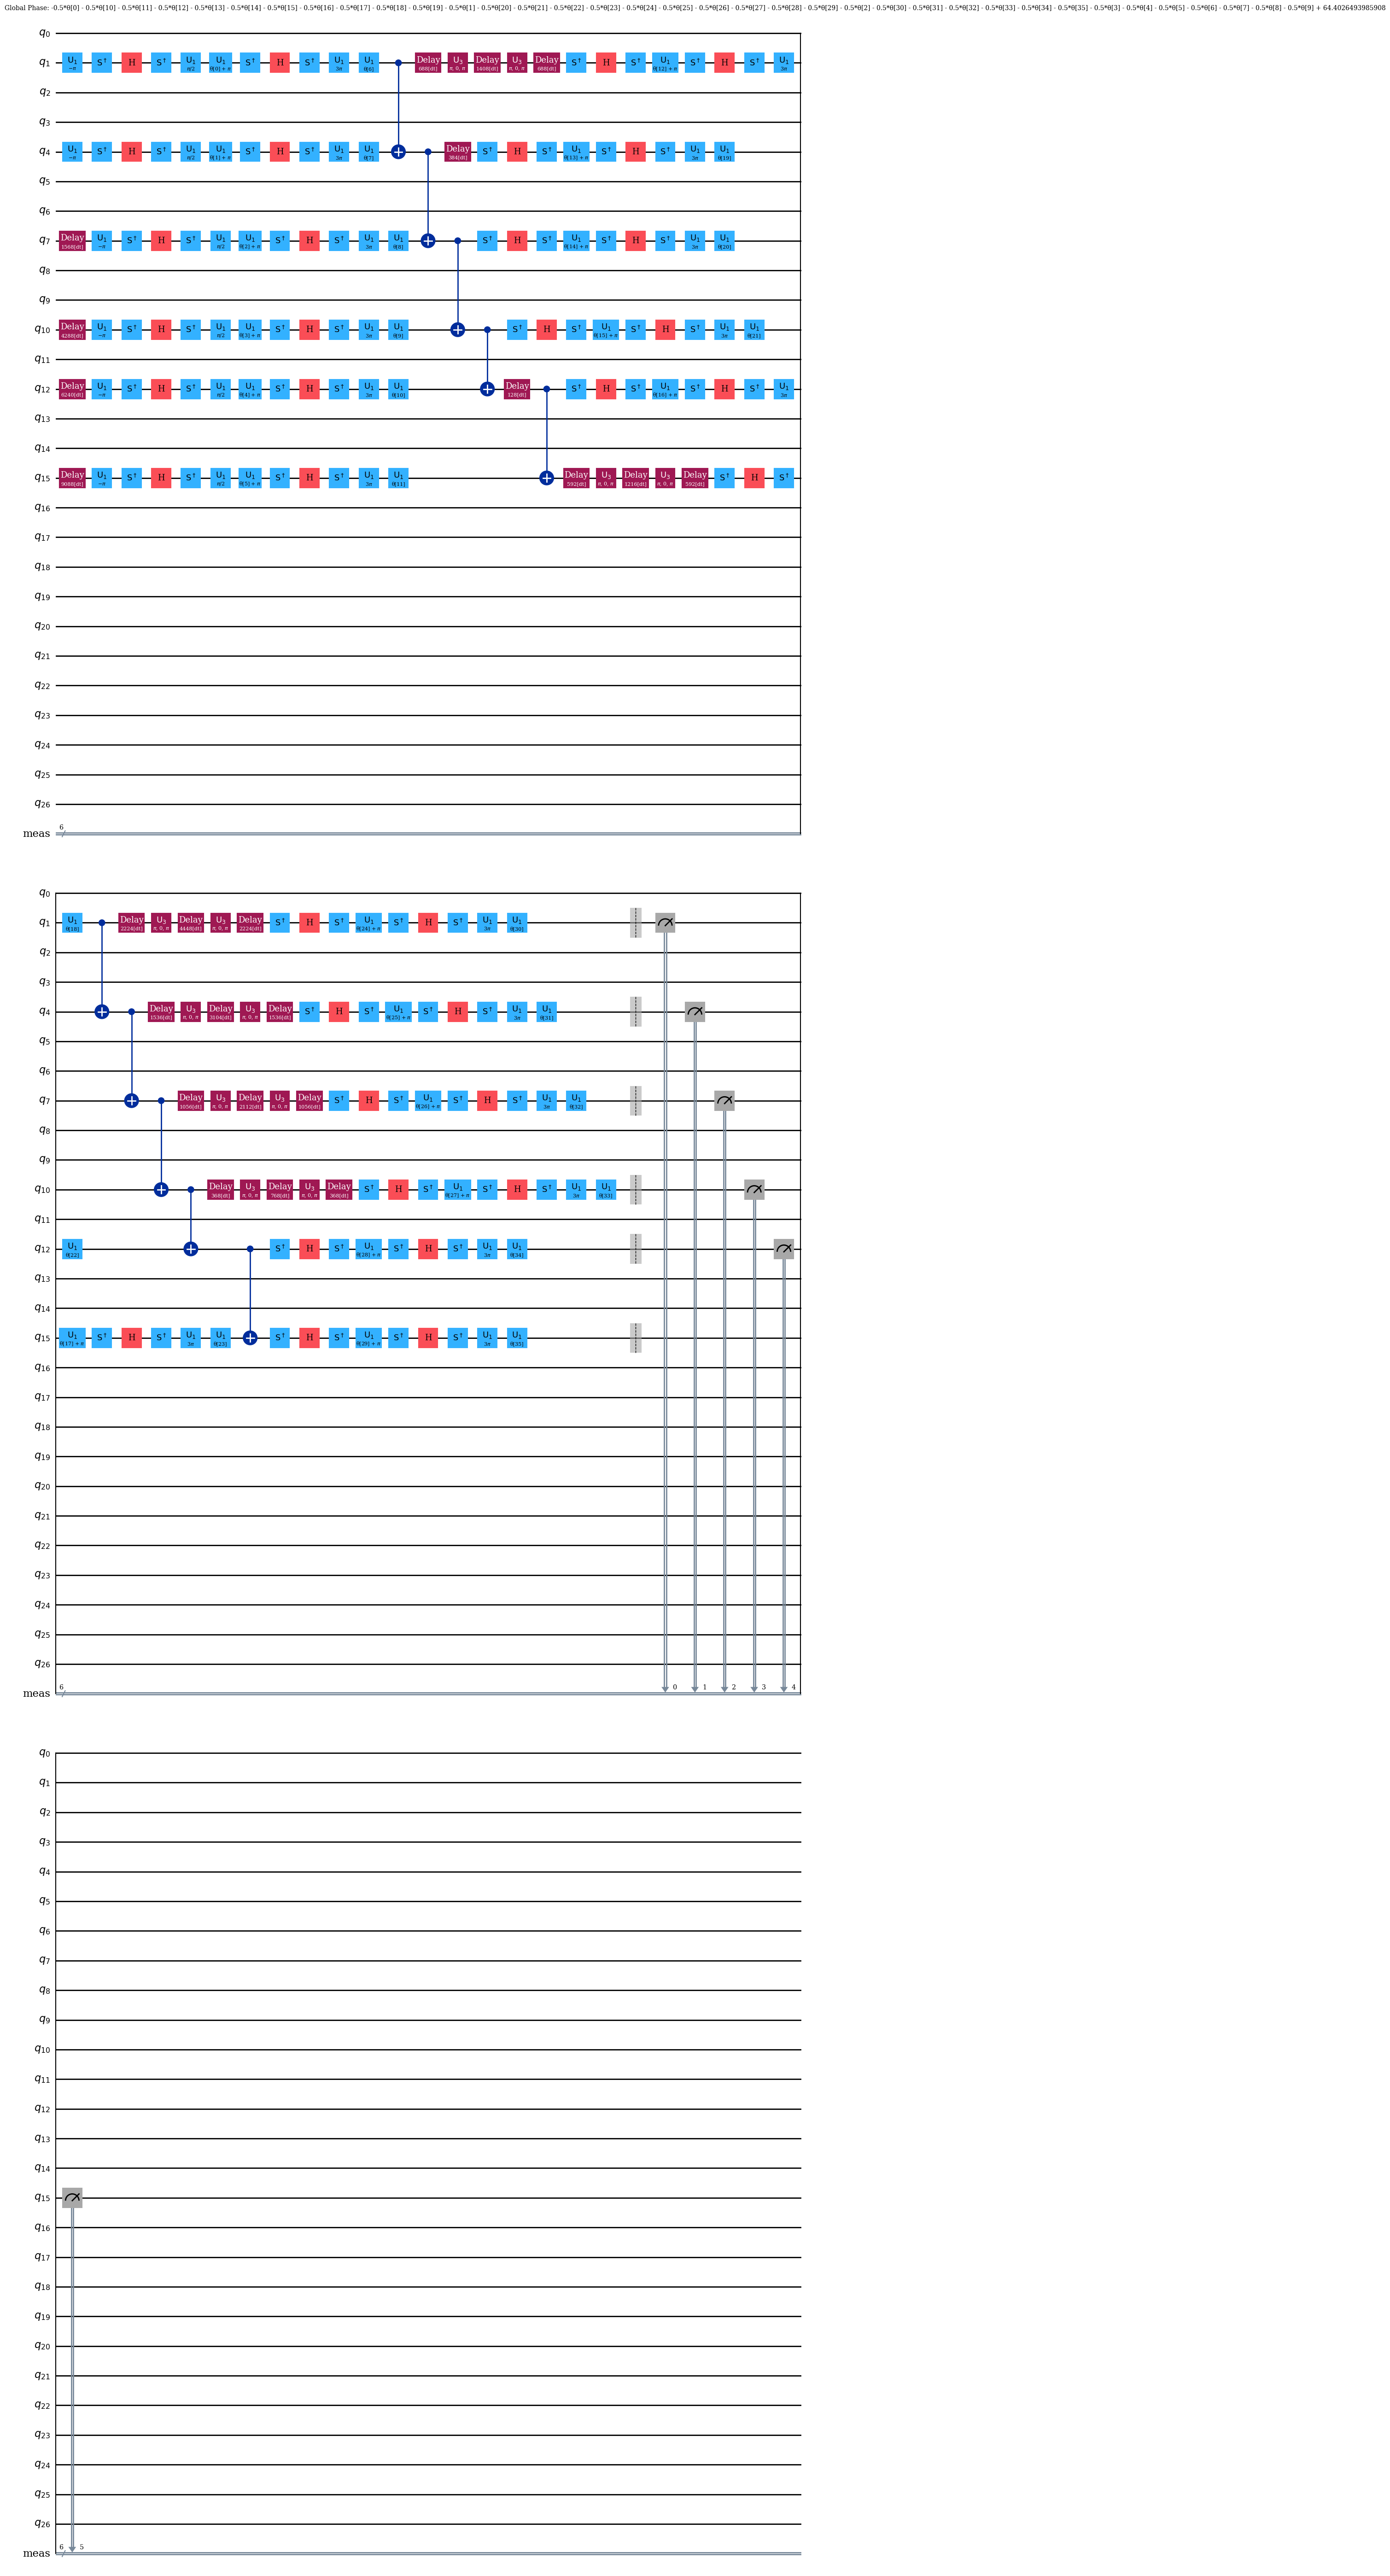

In [16]:
#qc.decompose().draw('mpl', style='iqp', filename = 'circuit.pdf')
qc_transpiled.decompose().draw('mpl', style='iqp', filename = 'transpiled_circuit.pdf')

In [17]:
def get_cost_tv(p_data, sampler, circuit, shots, history):
    def cost_tv_fun(parameters):
        if shots == None:
            # For use with Sampler()
            prob = dist_pdf(dist(sampler, circuit, parameters))
        else:
            # For use with everything else
            prob = dist_pdf(sampler.run(circuits=circuit, parameter_values=parameters, shots = shots).result().quasi_dists[0].nearest_probability_distribution())
        cost = np.sum(np.abs(prob-p_data)**2)
        if history != None:
            history.append(cost)
        return cost
    return cost_tv_fun

In [18]:
def get_cost_mmd(p_data, mmd, sampler, circuit, shots, history):
    def cost_mmd_fun(parameters):
        if shots == None:
            # For use with Sampler()
            prob = dist_pdf(dist(sampler, circuit, parameters))
        else:
            # For use with everything else
            prob = dist_pdf(sampler.run(circuits=circuit, parameter_values=parameters, shots = shots).result().quasi_dists[0].nearest_probability_distribution())
        cost = self.mmd.calc(prob, self.p_data)
        if history != None:
            history.append(cost)
        return cost
    return cost_mmd_fun

In [19]:
def get_gradient_analytic(p_data, mmd, sampler, circuit, shots, history_cost, history_grad):
    def gradient_analytic(parameters):
        num_of_par = len(parameters)
        circuits_list = [circuit] * (2 * num_of_par + 1) 
        parameters_list = []
        gradient = []
        parameters_list.append(parameters.copy())
        for i in range(num_of_par):
            # pi/2 phase
            pars_plus = parameters.copy()
            pars_plus[i] += np.pi/2
            parameters_list.append(pars_plus)
            # -pi/2 phase
            pars_minus = parameters.copy()
            pars_minus[i] -= np.pi/2
            parameters_list.append(pars_minus)
        if shots == None:
            jobs = sampler.run(circuits=circuits_list, parameter_values=parameters_list)
        else:
            jobs = sampler.run(circuits=circuits_list, parameter_values=parameters_list, shots = shots)
        results = jobs.result()
        pd_list = []
        for qd in results.quasi_dists:
            pd_list.append(dist_pdf(qd.nearest_probability_distribution()))
        prob = pd_list[0]
        for i in range(1, 2 * num_of_par + 1, 2):
            prob_plus = pd_list[i]
            prob_minus = pd_list[i + 1]
            grad_plus = mmd.kernel_expect(prob, prob_plus) - mmd.kernel_expect(prob, prob_minus)
            grad_minus = mmd.kernel_expect(self.p_data, prob_plus) - mmd.kernel_expect(self.p_data, prob_minus)
            gradient.append(grad_plus - grad_minus)
        if history_cost != None:
            history_cost.append(prob)
        if history_grad != None:
            history_grad.append(gradient)
        return np.array(gradient)
    return gradient_analytic

In [20]:
# Prepare data
coords = np.linspace(-4, 4, num_discrete_values)
normal = norm(loc=0.0, scale=1)
#prob_data = normal.pdf(coords)
prob_data = 0.4 * norm(loc=-3, scale=0.3).pdf(coords) + 0.3 * norm(loc=1, scale=0.3).pdf(coords) + 0.2 * norm(loc=3, scale=0.6).pdf(coords) + 0.1 * norm(loc=-1, scale=0.6).pdf(coords)
prob_data = prob_data / np.sum(prob_data)

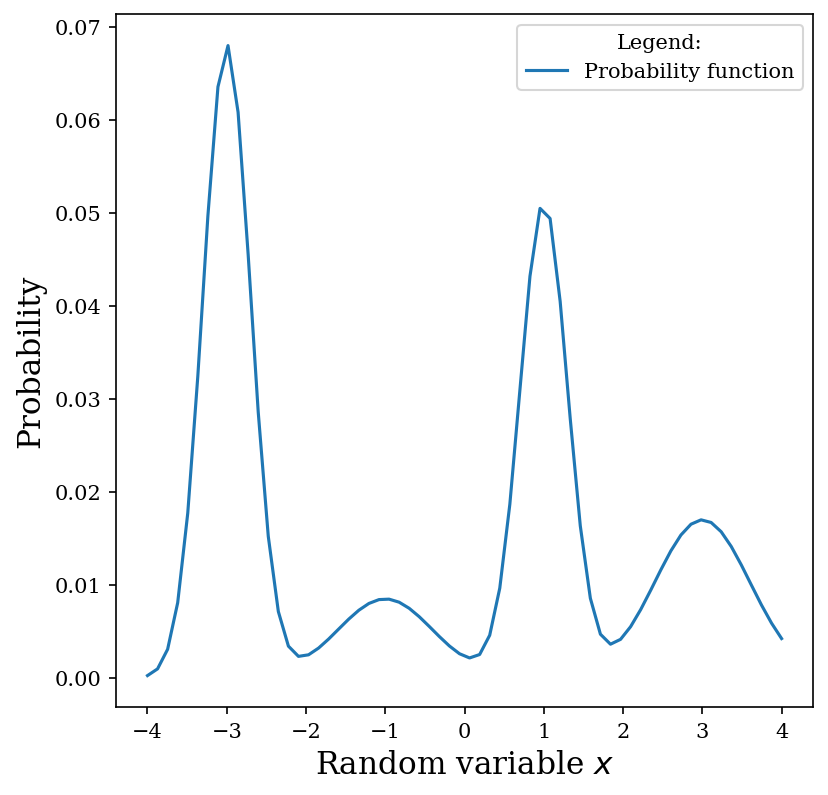

In [21]:
# Visualize data
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.plot(coords, prob_data, label = 'Probability function')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-prob_data.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
MMD = mmd(sigma_list=[0.4,8], basis=np.arange(2**num_qubits), kernel=rbf_kernel)

In [37]:
# Set Sampler
# local Aer
#local_sampler = pdf_sampler = AerSampler(backend_options={'noise_model' : noise_model, "seed_simulator": algorithm_globals.random_seed, "method": 'density_matrix', "device": "GPU", "batched_shots_gpu": True}, skip_transpilation = True)
# local Base
#local_sampler = pdf_sampler = Sampler()
# IBM
#sampler = 'IBM'

In [23]:
def build_callback(callback_dict):
    def callback(current_vector):
        callback_dict["iters"] += 1
        callback_dict["tqdm"].update(1)
        callback_dict["par_hist"].append(current_vector)
    return callback

In [24]:
# COBYLA training
def train_cobyla(init_params = None, circuit = None, max_iter = 1000, ibm = False, shots = None):
    t = tqdm(total=max_iter)
    callback_dict = {
        "iters": 0,
        "tqdm": t,
        "par_hist" : []
    }
    cost_history = []
    callback = build_callback(callback_dict)
    #optimizer = COBYLA(maxiter = max_iter, tol=1e-8, rhobeg=1.0)
    if not np.all(init_params):
        parameters = np.zeros(circuit.num_parameters)
    else:
        parameters = init_params
    if ibm:
        with Session(service, backend=backend) as session:
            ibmsampler = IBMSampler(session=session, options=options)
            cost_fun = get_cost_tv(prob_data, ibmsampler, circuit.copy(), shots, cost_history)
            optimizer_result = minimize(
                fun = cost_fun,
                x0 = parameters,
                method="cobyla",
                callback=callback,
                bounds = [(-np.pi,np.pi) for a in range(len(parameters))],
                tol = 1e-8,
                options = {'maxiter': max_iter, 'rhobeg' : 0.3}
            )
            #optimizer_result = optimizer.minimize(fun = cost_fun, x0 = parameters, bounds = [(-np.pi,np.pi) for a in range(len(parameters))]) 
    else:
        cost_fun = get_cost_tv(prob_data, local_sampler, circuit.copy(), shots, cost_history)
        optimizer_result = minimize(
            fun = cost_fun,
            x0 = parameters,
            method="cobyla",
            callback=callback,
            bounds = [(-np.pi,np.pi) for a in range(len(parameters))],
            tol = 1e-8,
            options = {'maxiter': max_iter, 'rhobeg' : 1.0}
        )
        #optimizer_result = optimizer.minimize(fun = cost_fun, x0 = parameters, bounds = [(-np.pi,np.pi) for a in range(len(parameters))]) 
    t.close()
    return optimizer_result, cost_history, callback_dict

In [25]:
def bin_mean(data, bin_size):
    if (len(data)%bin_size):
        raise ValueError
    bin_data = []
    for i in range(0, len(data), bin_size):
        bin_data.append(np.mean(data[i:i+bin_size]))
    return bin_data

## Find Optimal Depth

In [28]:
from cmaes import CMA, CMAwM, get_warm_start_mgd

In [26]:
local_sampler = pdf_sampler = AerSampler(
    backend_options={
        "noise_model": noise_model,
        "seed_simulator": algorithm_globals.random_seed,
        "method": 'statevector',
        "device": "CPU",
    },
    skip_transpilation=True
)

In [34]:
depth_cmaes_x = []
depth_cmaes_fun = []
num_generations = 100
for depth in tqdm(range(1,11)):
    dqr = QuantumRegister(num_qubits)
    dqc = QuantumCircuit(qr)
    dqc.h(dqc.qubits)
    dansatz = EfficientSU2(num_qubits, entanglement='linear', reps=depth)
    dqc.compose(dansatz, inplace=True)
    dqc.measure_all()
    dqc_transpiled = pm.run(dqc)
    cma_cost_history = []
    cma_parameter_history = []
    cma_optimizer = CMA(mean=np.zeros(dqc.num_parameters), sigma=0.5, bounds = np.array([[-np.pi/2,np.pi/2] for _ in range(dqc.num_parameters)]))
    for generation in tqdm(range(num_generations)):
        solutions = []
        x_list = []
        costs = []
        for _ in range(cma_optimizer.population_size):
            x = cma_optimizer.ask()
            x_list.append(x)
            cma_parameter_history.append(x)
        cma_circuits = [dqc_transpiled] * cma_optimizer.population_size
        job = local_sampler.run(circuits=cma_circuits, parameter_values=x_list, shots = 4000)
        res = job.result()
        pds = []
        for qd in res.quasi_dists:
            pds.append(dist_pdf(qd.nearest_probability_distribution()))
        for pd in pds:
            cost = np.sum(np.abs(pd-prob_data)**2)
            costs.append(cost)
            cma_cost_history.append(cost)
        for i in range(len(costs)):
            solutions.append((x_list[i], costs[i]))
        cma_optimizer.tell(solutions)
        np.savetxt('E1-CMAES_costhistD' + str(depth) + '.txt', cma_cost_history)
        np.savetxt('E1-CMAES_parhistD'+ str(depth) + '.txt', cma_parameter_history)
        depth_cmaes_x.append(x_list[np.argmin(costs)])
        depth_cmaes_fun.append(np.min(costs))
        if cma_optimizer.should_stop():
                break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
np.savetxt('RP01E1OD-cobylaD-nfev.txt', depth_cobyla_nfev)
np.savetxt('RP01E1OD-cobylaD-fun.txt', depth_cobyla_fun)
#np.savetxt('RP01E1OD-cobylaD-x.txt', depth_cobyla_x)

In [37]:
aaa = []
for i in range(0,1000,100):
    aaa.append(depth_cmaes_fun[i])

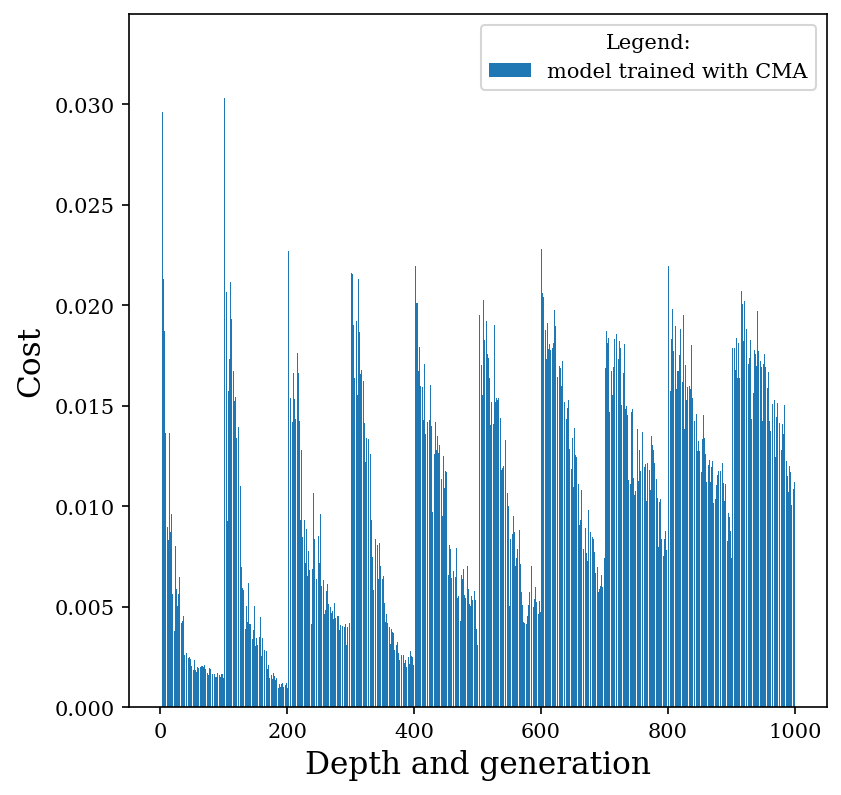

In [48]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(range(1,len(depth_cmaes_fun)+1), depth_cmaes_fun, label='model trained with CMA')
#ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='data')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Depth and generation', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-depth_cost.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
for depth in range(1,11):
    ph = np.loadtxt('RP01E1OD-cobylaD'+str(depth)+'-par_hist.txt')
    for it in ph.shape[0]:
        ph[it]

In [52]:
ph = np.loadtxt('RP01E1OD-cobylaD'+str(1)+'-par_hist.txt')

In [60]:
ph[0].shape

(48,)

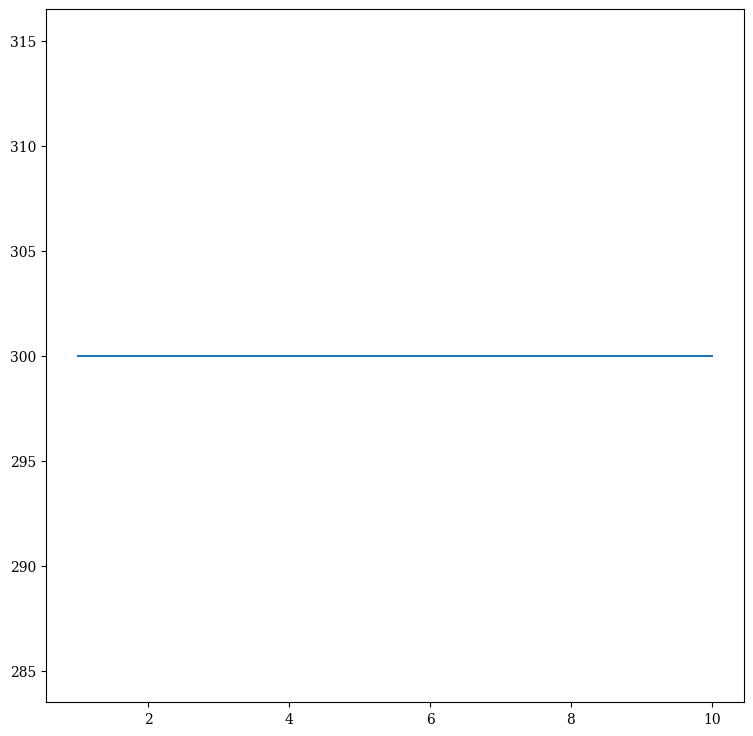

In [51]:
fig, ax = plt.subplots(figsize=(9, 9))
#plot = ax.plot(range(10), depth_cobyla_fun)
plot = ax.plot(range(1,11), depth_cobyla_nfev)
plt.show()

## Train with COBYLA

In [62]:
if False:
    local_sampler = pdf_sampler = Sampler()

In [29]:
local_sampler = pdf_sampler = AerSampler(
    backend_options={
        "noise_model": noise_model,
        "seed_simulator": algorithm_globals.random_seed,
        "method": 'statevector',
        "device": "CPU",
    },
    skip_transpilation=True
)

In [134]:
if False:
    from qiskit_aer.noise import NoiseModel
    from qiskit.providers.fake_provider import FakeMumbaiV2
    be = FakeMumbaiV2()
    noise_model = NoiseModel.from_backend(be)
    local_sampler = pdf_sampler = AerSampler(
        backend_options={
            "noise_model": noise_model,
            "seed_simulator": algorithm_globals.random_seed,
            "method": 'statevector',
            "device": "CPU",
        },
        skip_transpilation=True
    )

In [72]:
np.argmin(cma_cost_history)

41489

In [82]:
res_cobyla, hist_cobyla, callback_cobyla = train_cobyla(
    max_iter=1000,
    init_params=cma_parameter_history[np.argmin(cma_cost_history)],
    circuit=qc_transpiled.copy(),
    ibm = False, shots = 8000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [73]:
# Save data
if True:
    np.savetxt('RP01E1OD-cobyla-x.txt', res_cobyla.x)
    np.savetxt('RP01E1OD-cobyla-fun.txt', [res_cobyla.fun])
    np.savetxt('RP01E1OD-cobyla-nfev.txt', [res_cobyla.nfev])
    np.savetxt('RP01E1OD-cobyla-iters.txt', [callback_cobyla['iters']])
    np.savetxt('RP01E1OD-cobyla-par_hist.txt', callback_cobyla['par_hist'])

In [83]:
pdf_cobyla = dist_pdf(
    pdf_sampler.run(
        circuits=qc_transpiled,
        parameter_values=res_cobyla.x,
        shots = 8000).result().quasi_dists[0].nearest_probability_distribution()
)

In [ ]:
pdf_cobyla = dist_pdf(
    pdf_sampler.run(
        circuits=qc.copy(),
        parameter_values=res_cobyla.x
    ).result().quasi_dists[0]
)

In [137]:
bin_pdf_cobyla = bin_mean(pdf_cobyla, 64)

In [138]:
bin_prob_data = bin_mean(prob_data, 64)

In [139]:
bin_coords = bin_mean(coords, 64)

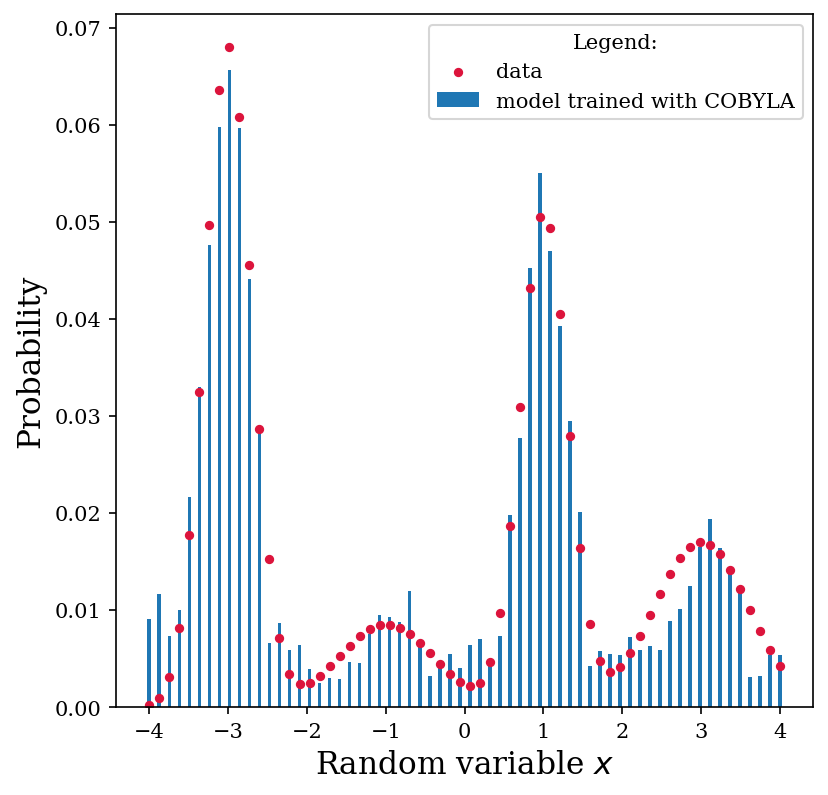

In [77]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(coords, pdf_cobyla, width=0.05, label='model trained with COBYLA')
ax.scatter(coords, prob_data, color='crimson', s=12, label='data')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-model_and_data300COBYLA.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()

In [84]:
print(res_cobyla.x)
print(res_cobyla.nfev)
print(res_cobyla.fun)

[ 0.60272456 -0.0341633  -0.13765831  0.23231138 -0.10809631  0.05915557
 -0.05326386  0.37608257 -0.3705916  -0.11188501 -0.51202405 -0.86223512
 -0.86623975 -0.00169324 -0.25311436  1.52330974 -0.10160999 -0.25798098
 -0.13644677  0.16991245  1.33931638 -0.17104146 -0.0610393   0.20037427
  0.27501538  0.29320721 -0.24562291  0.07670436 -0.71066142 -0.08652828
  0.8029057  -0.62597489  0.25631207 -0.00864071  0.46005052 -0.52982046]
566
0.0007306493310467319


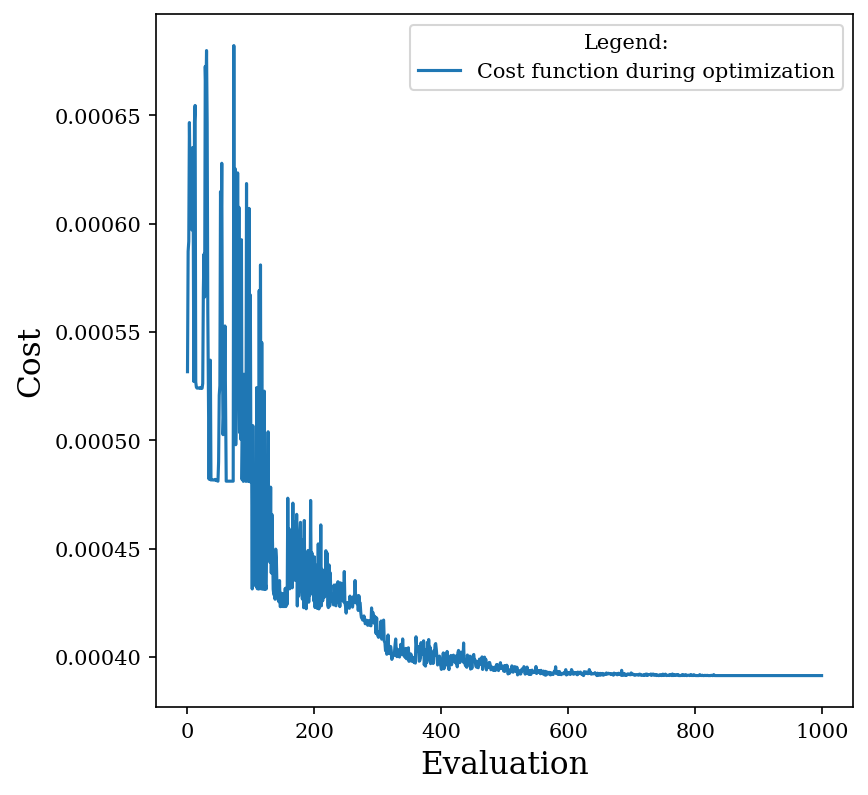

In [152]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(res_cobyla.nfev), hist_cobyla, label = 'Cost function during optimization')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Evaluation', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-cost_evaluation.pdf', format='pdf')
plt.show()

In [160]:
cost_history = []
cost_sampler = local_sampler
cost_tv_fun = get_cost_tv(prob_data, cost_sampler, qc_transpiled, 8000, cost_history)
for par in tqdm(callback_cobyla['par_hist']):
    cost_tv_fun(par)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [163]:
np.savetxt('RP01E1OD-cobyla-cost_history.txt', cost_history)

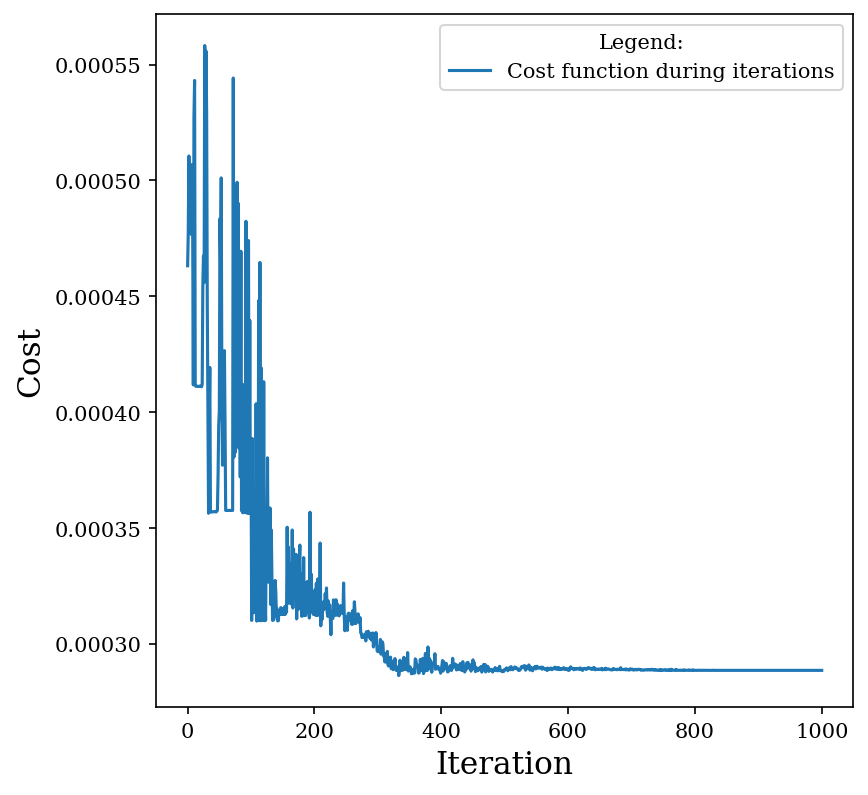

In [164]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(len(cost_history)), cost_history, label = 'Cost function during iterations')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Iteration', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-cost_iterations.pdf', format='pdf')

## Running on quantum computer

In [40]:
magic_pars = [ 1.23755452e-01, -3.76964856e-02,  5.60494397e-02, -4.17135359e-02,
       -3.14007136e-02, -2.18024476e-02, -2.73018927e-02, -1.10067429e-02,
       -1.43420037e-01,  2.26471514e-01, -2.07490220e-01,  3.74818647e-02,
        4.84856410e-01, -1.34878651e-01, -1.23759748e-01, -4.75583203e-01,
        1.10965291e+00,  1.00604288e+00,  2.59942545e-01, -4.08609331e-01,
       -6.14492567e-02, -1.19473367e-01,  4.98984271e-01, -1.63716513e-01,
        1.64557278e-02, -4.52633888e-02,  7.01532711e-02,  3.09437408e-04,
       -9.30559615e-03, -4.93596716e-02,  5.41725211e-03,  2.19073245e-02,
       -3.86618562e-01,  1.52539588e+00,  4.96920618e-02, -2.04716024e-01,
       -1.20967770e-01, -2.39686754e-01, -1.39075116e-02,  4.13115354e-01,
        2.26808406e-01, -9.27101161e-02, -5.12427289e-02, -2.03298795e-01,
       -2.25944883e-01,  3.62082422e-01,  2.21824843e-02,  4.79240660e-02,
        1.20746565e-01,  2.38115368e-02,  2.08544575e-02,  6.21022290e-02,
        2.84442471e-02, -2.62016168e-03,  1.20641739e-03,  4.16559038e-02,
       -5.69005445e-01,  3.37133312e-01, -8.69421957e-01, -5.52139591e-02,
        1.25016140e-01,  1.13588346e-01, -9.45400028e-02,  1.10330822e-01,
        9.22008234e-02,  3.41104452e-01,  1.15785494e-01, -1.58295841e-01,
        1.05708294e-01,  1.93626376e-01,  8.24189971e-02,  1.47807324e-01]

In [111]:
Qparameters_list = callback_cobyla['par_hist'].copy()
Qcircuits_list = [qc_transpiled] * len(Qparameters_list)
Qshots = 8000
Qcost_history = []
with Session(service, backend=backend) as session:
    ibmsampler = IBMSampler(session=session, options=options)
    Qjobs = ibmsampler.run(circuits=Qcircuits_list, parameter_values=Qparameters_list, shots = Qshots)
    session.cancel()

In [ ]:
Qresults = Qjobs.result()
Qpd_list = []
for qd in Qresults.quasi_dists:
    Qpd_list.append(dist_pdf(qd.nearest_probability_distribution()))
np.savetxt('RP01-QCBM-Qpd_list.txt', Qpd_list)

In [ ]:
Qcost_list = []
for pd in Qpd_list:
    Qcost_list.append(np.sum(np.abs(prob_data-pd)**2))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(len(Qcost_list)), Qcost_list, label = 'Quantum computed cost')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Iteration', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-Qcost_iterations.pdf', format='pdf')

In [150]:
from qiskit.visualization import plot_error_map, plot_circuit_layout

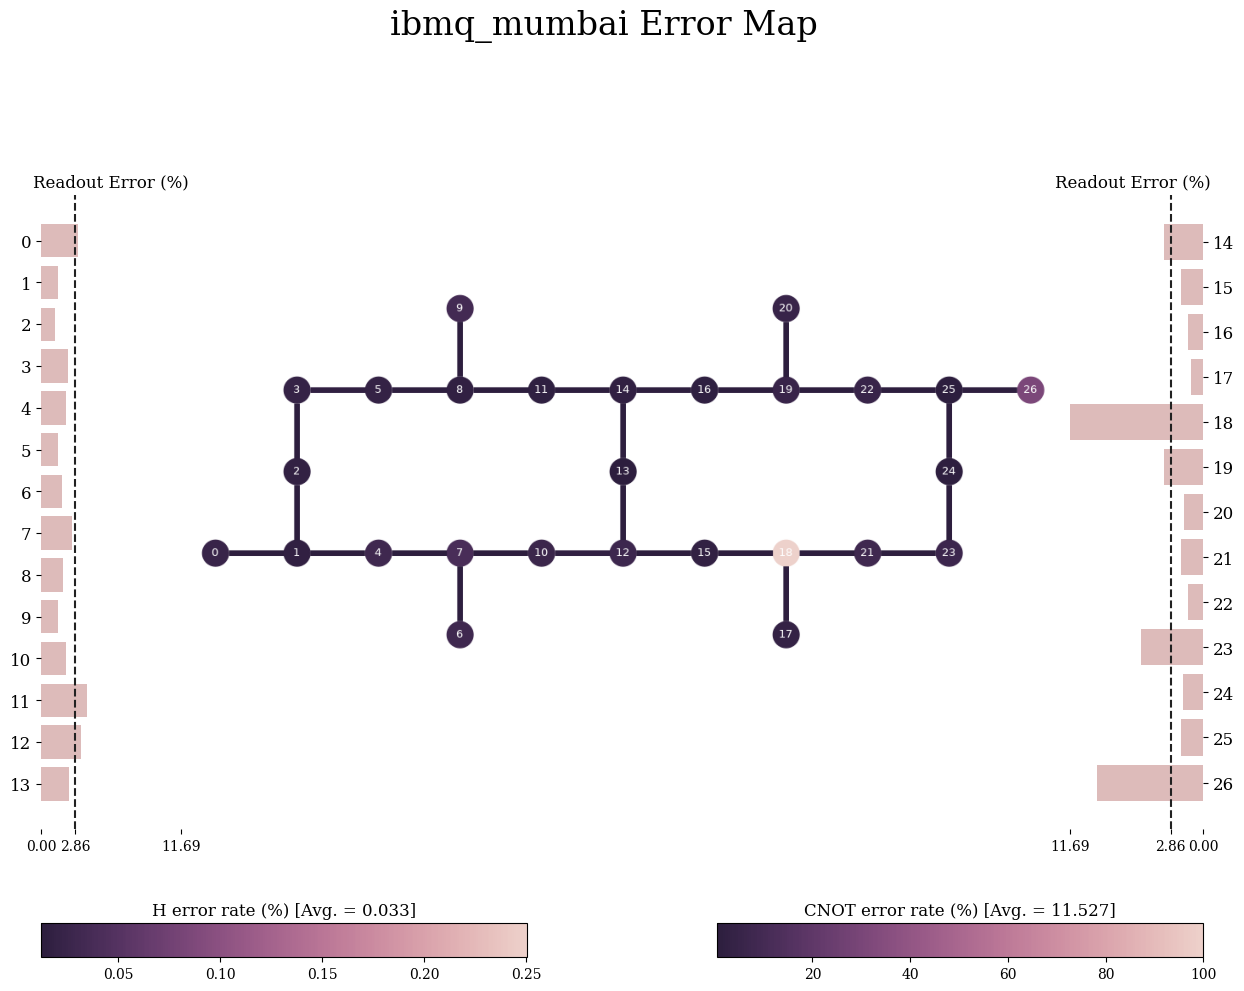

In [149]:
plot_error_map(backend)

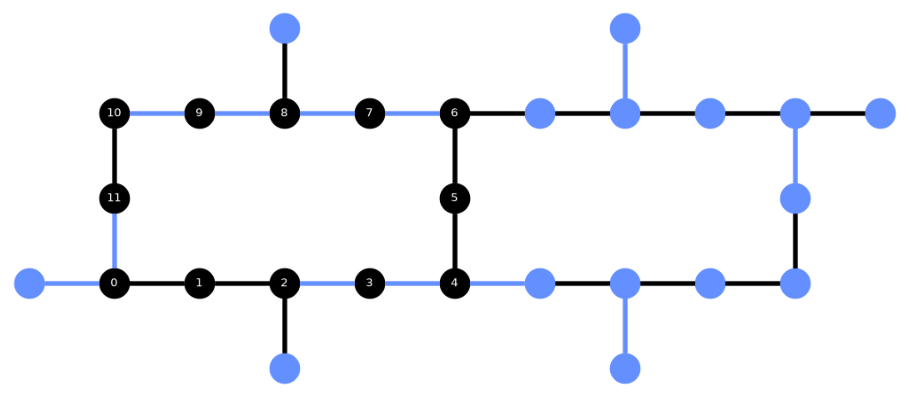

In [151]:
plot_circuit_layout(qc_transpiled, backend)

In [155]:
from qiskit_aer.version import get_version_info

In [157]:
get_version_info()

'0.13.2'

## CMA-ES optimizer

In [41]:
local_sampler = pdf_sampler = AerSampler(
    backend_options={
        "noise_model": noise_model,
        "seed_simulator": algorithm_globals.random_seed,
        "method": 'statevector',
        "device": "CPU",
    },
    skip_transpilation=True
)

In [42]:
from cmaes import CMA, CMAwM, get_warm_start_mgd

In [ ]:
help(CMA)

In order to find reasonble settings the CMA-ES was first run with "default" settings, and now we use the warm start helper function to generate settings

In [45]:
# CMA without warmstart
cma_optimizer = CMA(mean=np.zeros(qc.num_parameters), sigma=0.2, bounds = np.array([[-np.pi/2,np.pi/2] for _ in range(qc.num_parameters)]))

In [100]:
ws_mean, ws_sigma, ws_cov = get_warm_start_mgd(
        list(zip(np.loadtxt('E1-CMAES_parhist_old.txt'), np.loadtxt('E1-CMAES_costhist_old.txt'))), gamma=0.1, alpha=0.1
    )
print('warmstart mean:', ws_mean)
print('warmstar sigma:', ws_sigma)
print('warmstart covarince matrix', ws_cov)

warmstart mean: [-0.15433512 -0.00714801 -0.15505625  0.22724274  0.23482339  0.08337365
 -0.47000463 -0.65387015  0.52403712 -0.04970639  0.49993618  0.79382335
  0.04538669 -0.12214732 -0.35372708  1.37926292 -0.00774544 -0.42339855
  0.95993136 -0.00660619 -0.04494222  0.63300187  0.36526204  0.42005143
  0.22546043  0.03916336 -0.27178161  0.0736345  -0.76958903  0.05868214
 -0.21734312 -0.44026794 -0.68033634 -0.19657601  1.52525817 -0.6319484 ]
warmstar sigma: 0.10315229115355275
warmstart covarince matrix [[ 0.98044787  0.008288    0.00685976 ...  0.01289158  0.01249811
  -0.00645372]
 [ 0.008288    1.02670321 -0.05640213 ...  0.05034135  0.0236042
   0.05621541]
 [ 0.00685976 -0.05640213  1.00639532 ... -0.05249496  0.00639382
  -0.04953414]
 ...
 [ 0.01289158  0.05034135 -0.05249496 ...  1.03866388 -0.02747003
   0.0308942 ]
 [ 0.01249811  0.0236042   0.00639382 ... -0.02747003  1.03450117
   0.00299263]
 [-0.00645372  0.05621541 -0.04953414 ...  0.0308942   0.00299263
   1.05

In [ ]:
cma_optimizer = CMA(mean=ws_mean, sigma=ws_sigma, cov=ws_cov, bounds = np.array([[-np.pi/2,np.pi/2] for _ in range(qc.num_parameters)]))

In [104]:
# Loaded correct data?
len(ws_mean) == qc.num_parameters

True

In [46]:
cma_optimizer.population_size

14

In [47]:
#Expected number of simulations
num_generations = 3000
print('Maximum number of evaluations:',num_generations*cma_optimizer.population_size)

Maximum number of evaluations: 42000


In [48]:
cma_parameter_history = []
cma_cost_history = []

In [49]:
#Training loop for CMA-ES optimizer on local simulator
# The the history arrays are written in each loop to mitigate possible data loss
for generation in tqdm(range(num_generations)):
    solutions = []
    x_list = []
    val_list = []
    for _ in range(cma_optimizer.population_size):
        x = cma_optimizer.ask()
        x_list.append(x)
        cma_parameter_history.append(x)
    cma_circuits = [qc_transpiled] * cma_optimizer.population_size
    job = local_sampler.run(circuits=cma_circuits, parameter_values=x_list, shots = 300 + generation)
    res = job.result()
    pds = []
    for qd in res.quasi_dists:
        pds.append(dist_pdf(qd.nearest_probability_distribution()))
    costs = []
    for pd in pds:
        cost = np.sum(np.abs(pd-prob_data)**2)
        costs.append(cost)
        cma_cost_history.append(cost)
    for i in range(len(costs)):
        solutions.append((x_list[i], costs[i]))
    cma_optimizer.tell(solutions)
    np.savetxt('E1-CMAES_costhist.txt', cma_cost_history)
    np.savetxt('E1-CMAES_parhist.txt', cma_parameter_history)
    if cma_optimizer.should_stop():
            break

  0%|          | 0/3000 [00:00<?, ?it/s]

In [56]:
cma_cost_history[-1]

0.001163191343610234

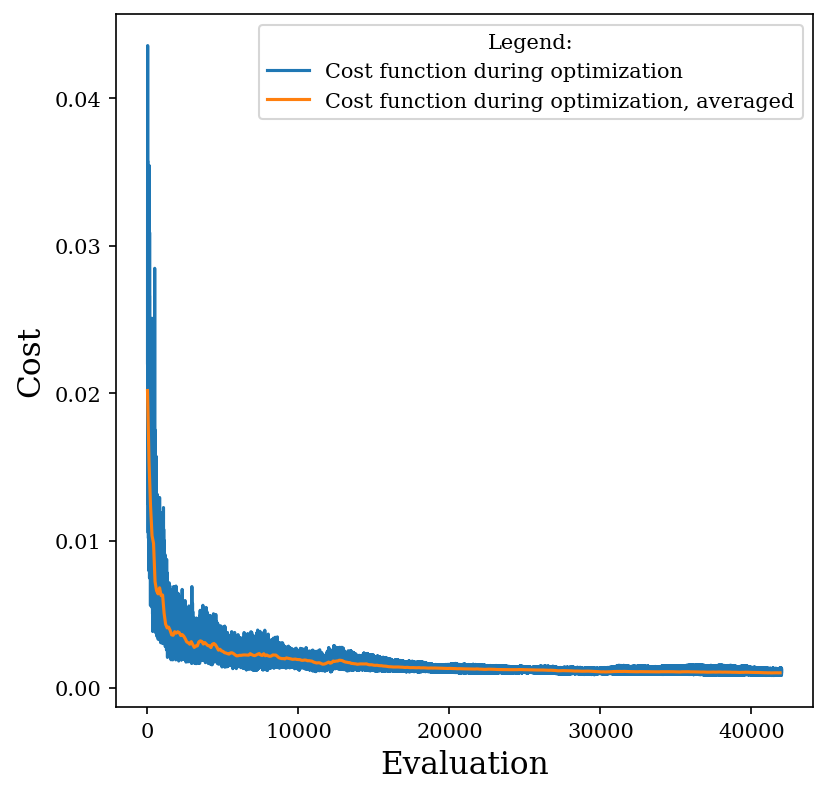

In [50]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(len(cma_cost_history)), cma_cost_history, label = 'Cost function during optimization')
plot = ax.plot(range(0,len(cma_cost_history), 100), bin_mean(cma_cost_history,100), label = 'Cost function during optimization, averaged')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Evaluation', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-cost_evaluationCMA3000.pdf', format='pdf')
plt.show()

In [51]:
np.savetxt('E1-CMAES-costhist.txt', cma_cost_history)

In [52]:
np.savetxt('E1-CMAES-parhist.txt', cma_parameter_history)

In [53]:
pdf_cma = dist_pdf(
    pdf_sampler.run(
        circuits=qc_transpiled,
        parameter_values=cma_parameter_history[-1],
        shots = 8000).result().quasi_dists[0].nearest_probability_distribution()
)

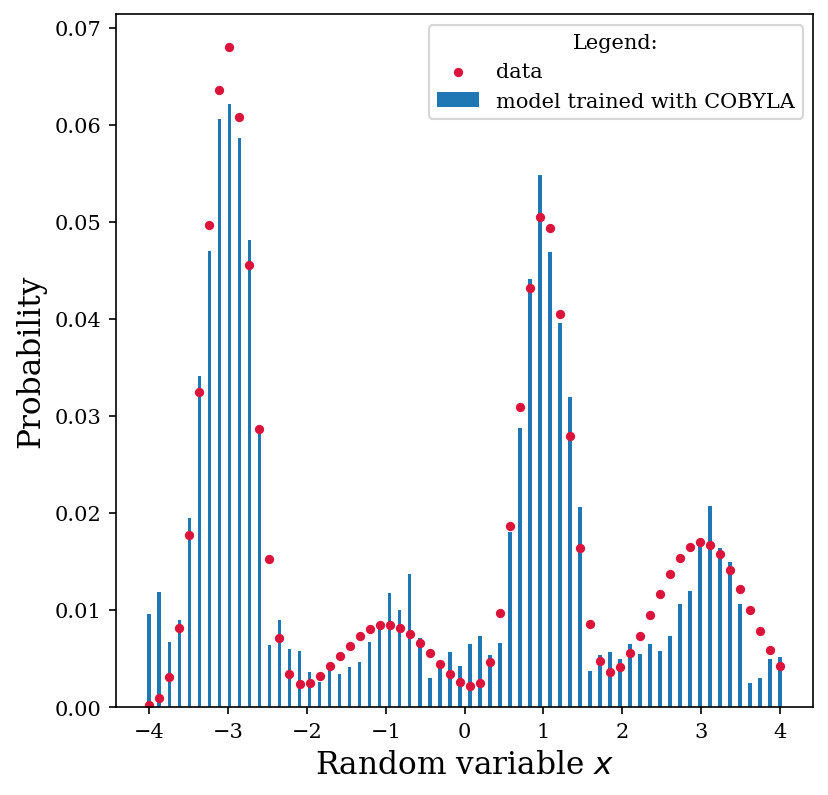

In [54]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(coords, pdf_cma, width=0.05, label='model trained with COBYLA')
ax.scatter(coords, prob_data, color='crimson', s=12, label='data')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
#plt.savefig('RP01-QCBM-E1-model_and_data.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()

In [49]:
import numpy as np

In [50]:
np.min(np.loadtxt('E1-CMAES-costhist.txt'))

0.0008408294278103316